# What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you choose to work with that notebook).

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

**Acknowledgement: This exercise is adapted from [Stanford CS231n](http://cs231n.stanford.edu/index.html).**

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

**NOTE: This notebook is meant to teach you the latest version of Tensorflow 2.0. Most examples on the web today are still in 1.x, so be careful not to confuse the two when looking up documentation**.

## Install Tensorflow 2.0
Tensorflow 2.0 is still not in a fully 100% stable release, but it's still usable and more intuitive than TF 1.x. Please make sure you have it installed before moving on in this notebook! Here are some steps to get started:

1. Have the latest version of Anaconda installed on your machine.
2. Create a new conda environment starting from Python 3.7. In this setup example, we'll call it `tf_20_env`.
3. Run the command: `source activate tf_20_env`
4. Then pip install TF 2.0 as described here: https://www.tensorflow.org/install/pip 

A guide on creating Anaconda enviornments: https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/

This will give you an new enviornemnt to play in TF 2.0. Generally, if you plan to also use TensorFlow in your other projects, you might also want to keep a seperate Conda environment or virtualenv in Python 3.7 that has Tensorflow 1.9, so you can switch back and forth at will. 

**Acknowledgement: This exercise is adapted from [Stanford CS231n](http://cs231n.stanford.edu/index.html).**

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

# Part I: Preparation

In [1]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [4]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


You can optionally **use GPU by setting the flag to True below**. It's not neccessary to use a GPU for this assignment; if you are working on Google Cloud then we recommend that you do not use a GPU, as it will be significantly more expensive.

In [5]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Part II: Barebones TensorFlow
TensorFlow ships with various high-level APIs which make it very convenient to define and train neural networks; we will cover some of these constructs in Part III and Part IV of this notebook. In this section we will start by building a model with basic TensorFlow constructs to help you better understand what's going on under the hood of the higher-level APIs.

**"Barebones Tensorflow" is important to understanding the building blocks of TensorFlow, but much of it involves concepts from TensorFlow 1.x.** We will be working with legacy modules such as `tf.Variable`.

Therefore, please read and understand the differences between legacy (1.x) TF and the new (2.0) TF.

### Historical background on TensorFlow 1.x

TensorFlow 1.x is primarily a framework for working with **static computational graphs**. Nodes in the computational graph are Tensors which will hold n-dimensional arrays when the graph is run; edges in the graph represent functions that will operate on Tensors when the graph is run to actually perform useful computation.

Before Tensorflow 2.0, we had to configure the graph into two phases. There are plenty of tutorials online that explain this two-step process. The process generally looks like the following for TF 1.x:
1. **Build a computational graph that describes the computation that you want to perform**. This stage doesn't actually perform any computation; it just builds up a symbolic representation of your computation. This stage will typically define one or more `placeholder` objects that represent inputs to the computational graph.
2. **Run the computational graph many times.** Each time the graph is run (e.g. for one gradient descent step) you will specify which parts of the graph you want to compute, and pass a `feed_dict` dictionary that will give concrete values to any `placeholder`s in the graph.

### The new paradigm in Tensorflow 2.0
Now, with Tensorflow 2.0, we can simply adopt a functional form that is more Pythonic and similar in spirit to PyTorch and direct Numpy operation. Instead of the 2-step paradigm with computation graphs, making it (among other things) easier to debug TF code. You can read more details at https://www.tensorflow.org/guide/eager.

The main difference between the TF 1.x and 2.0 approach is that the 2.0 approach doesn't make use of `tf.Session`, `tf.run`, `placeholder`, `feed_dict`. To get more details of what's different between the two version and how to convert between the two, check out the official migration guide: https://www.tensorflow.org/alpha/guide/migration_guide

Later, in the rest of this notebook we'll focus on this new, simpler approach.

### TensorFlow warmup: Flatten Function

We can see this in action by defining a simple `flatten` function that will reshape image data for use in a fully-connected network.

In TensorFlow, data for convolutional feature maps is typically stored in a Tensor of shape N x H x W x C where:

- N is the number of datapoints (minibatch size)
- H is the height of the feature map
- W is the width of the feature map
- C is the number of channels in the feature map

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `H x W x C` values per representation into a single long vector. 

Notice the `tf.reshape` call has the target shape as `(N, -1)`, meaning it will reshape/keep the first dimension to be N, and then infer as necessary what the second dimension is in the output, so we can collapse the remaining dimensions from the input properly.

**NOTE**: TensorFlow and PyTorch differ on the default Tensor layout; TensorFlow uses N x H x W x C but PyTorch uses N x C x H x W.

In [6]:
def flatten(x):
    """    
    Input:
    - TensorFlow Tensor of shape (N, D1, ..., DM)
    
    Output:
    - TensorFlow Tensor of shape (N, D1 * ... * DM)
    """
    N = tf.shape(x)[0]
    return tf.reshape(x, (N, -1))

In [7]:
def test_flatten():
    # Construct concrete values of the input data x using numpy
    x_np = np.arange(24).reshape((2, 3, 4))
    print('x_np:\n', x_np, '\n')
    # Compute a concrete output value.
    x_flat_np = flatten(x_np)
    print('x_flat_np:\n', x_flat_np, '\n')

test_flatten()

x_np:
 [[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]] 

x_flat_np:
 tf.Tensor(
[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]], shape=(2, 12), dtype=int32) 



### Barebones TensorFlow: Define a Two-Layer Network
We will now implement our first neural network with TensorFlow: a fully-connected ReLU network with two hidden layers and no biases on the CIFAR10 dataset. For now we will use only low-level TensorFlow operators to define the network; later we will see how to use the higher-level abstractions provided by `tf.keras` to simplify the process.

We will define the forward pass of the network in the function `two_layer_fc`; this will accept TensorFlow Tensors for the inputs and weights of the network, and return a TensorFlow Tensor for the scores. 

After defining the network architecture in the `two_layer_fc` function, we will test the implementation by checking the shape of the output.

**It's important that you read and understand this implementation.**

In [8]:
def two_layer_fc(x, params):
    """
    A fully-connected neural network; the architecture is:
    fully-connected layer -> ReLU -> fully connected layer.
    Note that we only need to define the forward pass here; TensorFlow will take
    care of computing the gradients for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A TensorFlow Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of TensorFlow Tensors giving weights for the
      network, where w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A TensorFlow Tensor of shape (N, C) giving classification scores
      for the input data x.
    """
    w1, w2 = params                   # Unpack the parameters
    x = flatten(x)                    # Flatten the input; now x has shape (N, D)
    h = tf.nn.relu(tf.matmul(x, w1))  # Hidden layer: h has shape (N, H)
    scores = tf.matmul(h, w2)         # Compute scores of shape (N, C)
    return scores

In [9]:
def two_layer_fc_test():
    hidden_layer_size = 42

    # Scoping our TF operations under a tf.device context manager 
    # lets us tell TensorFlow where we want these Tensors to be
    # multiplied and/or operated on, e.g. on a CPU or a GPU.
    with tf.device(device):        
        x = tf.zeros((64, 32, 32, 3))
        w1 = tf.zeros((32 * 32 * 3, hidden_layer_size))
        w2 = tf.zeros((hidden_layer_size, 10))

        # Call our two_layer_fc function for the forward pass of the network.
        scores = two_layer_fc(x, [w1, w2])

    print(scores.shape)

two_layer_fc_test()

(64, 10)


### Barebones TensorFlow: Three-Layer ConvNet
Here you will complete the implementation of the function `three_layer_convnet` which will perform the forward pass of a three-layer convolutional network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for `C` classes.

**HINT**: For convolutions: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/conv2d; be careful with padding!

**HINT**: For biases: https://www.tensorflow.org/performance/xla/broadcasting

In [10]:
def three_layer_convnet(x, params):
    """
    A three-layer convolutional network with the architecture described above.
    
    Inputs:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: TensorFlow Tensor of shape (KH1, KW1, 3, channel_1) giving
        weights for the first convolutional layer.
      - conv_b1: TensorFlow Tensor of shape (channel_1,) giving biases for the
        first convolutional layer.
      - conv_w2: TensorFlow Tensor of shape (KH2, KW2, channel_1, channel_2)
        giving weights for the second convolutional layer
      - conv_b2: TensorFlow Tensor of shape (channel_2,) giving biases for the
        second convolutional layer.
      - fc_w: TensorFlow Tensor giving weights for the fully-connected layer.
        Can you figure out what the shape should be?
      - fc_b: TensorFlow Tensor giving biases for the fully-connected layer.
        Can you figure out what the shape should be?
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.            #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****

    layer1 = tf.nn.conv2d(x, conv_w1, strides=1, padding='SAME') + conv_b1#conv layer 1 with added bias
    relu1 = tf.nn.relu(layer1)
    layer2 = tf.nn.conv2d(relu1, conv_w2, strides=1, padding='SAME') + conv_b2 # conv layer 2 with added bias
    relu2 = tf.nn.relu(layer2)
    
    relu2 = flatten(relu2)
    
    scores = tf.matmul(relu2, fc_w) + fc_b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################
    return scores

After defing the forward pass of the three-layer ConvNet above, run the following cell to test your implementation. Like the two-layer network, we run the graph on a batch of zeros just to make sure the function doesn't crash, and produces outputs of the correct shape.

When you run this function, `scores_np` should have shape `(64, 10)`.

In [11]:
def three_layer_convnet_test():
    
    with tf.device(device):
        x = tf.zeros((64, 32, 32, 3))
        conv_w1 = tf.zeros((5, 5, 3, 6))
        conv_b1 = tf.zeros((6,))
        conv_w2 = tf.zeros((3, 3, 6, 9))
        conv_b2 = tf.zeros((9,))
        fc_w = tf.zeros((32 * 32 * 9, 10))
        fc_b = tf.zeros((10,))
        params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
        scores = three_layer_convnet(x, params)

    # Inputs to convolutional layers are 4-dimensional arrays with shape
    # [batch_size, height, width, channels]
    print('scores_np has shape: ', scores.shape)

three_layer_convnet_test()

scores_np has shape:  (64, 10)


### Barebones TensorFlow: Training Step

We now define the `training_step` function performs a single training step. This will take three basic steps:

1. Compute the loss
2. Compute the gradient of the loss with respect to all network weights
3. Make a weight update step using (stochastic) gradient descent.


We need to use a few new TensorFlow functions to do all of this:
- For computing the cross-entropy loss we'll use `tf.nn.sparse_softmax_cross_entropy_with_logits`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits

- For averaging the loss across a minibatch of data we'll use `tf.reduce_mean`:
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/reduce_mean

- For computing gradients of the loss with respect to the weights we'll use `tf.GradientTape` (useful for Eager execution):  https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

- We'll mutate the weight values stored in a TensorFlow Tensor using `tf.assign_sub` ("sub" is for subtraction): https://www.tensorflow.org/api_docs/python/tf/assign_sub 


In [12]:
def training_step(model_fn, x, y, params, learning_rate):
    with tf.GradientTape() as tape:
        scores = model_fn(x, params) # Forward pass of the model
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        total_loss = tf.reduce_mean(loss)
        grad_params = tape.gradient(total_loss, params)

        # Make a vanilla gradient descent step on all of the model parameters
        # Manually update the weights using assign_sub()
        for w, grad_w in zip(params, grad_params):
            w.assign_sub(learning_rate * grad_w)
                        
        return total_loss

In [13]:
def train_part2(model_fn, init_fn, learning_rate, epochs):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model
      using TensorFlow; it should have the following signature:
      scores = model_fn(x, params) where x is a TensorFlow Tensor giving a
      minibatch of image data, params is a list of TensorFlow Tensors holding
      the model weights, and scores is a TensorFlow Tensor of shape (N, C)
      giving scores for all elements of x.
    - init_fn: A Python function that initializes the parameters of the model.
      It should have the signature params = init_fn() where params is a list
      of TensorFlow Tensors holding the (randomly initialized) weights of the
      model.
    - learning_rate: Python float giving the learning rate to use for SGD.
    """
    
    
    params = init_fn()  # Initialize the model parameters            
    for e in range(epochs):    
        for t, (x_np, y_np) in enumerate(train_dset):
            # Run the graph on a batch of training data.
            loss = training_step(model_fn, x_np, y_np, params, learning_rate)

            # Periodically print the loss and check accuracy on the val set.
            if t % print_every == 0:
                print('Epoch %d, iteration %d, loss = %.4f' % (e, t, loss))
                print('Validation:')
                check_accuracy(val_dset, model_fn, params)
    return params
                

In [14]:
def check_accuracy(dset, model_fn, params):
    """
    Check accuracy on a classification model, e.g. for validation.
    
    Inputs:
    - dset: A Dataset object against which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - model_fn: the Model we will be calling to make predictions on x
    - params: parameters for the model_fn to work with
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        scores_np = model_fn(x_batch, params).numpy()
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('     Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### Barebones TensorFlow: Initialization
We'll use the following utility method to initialize the weight matrices for our models using Kaiming's normalization method.

[1] He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [15]:
def create_matrix_with_kaiming_normal(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape[0], shape[1]
    elif len(shape) == 4:
        fan_in, fan_out = np.prod(shape[:3]), shape[3]
    return tf.keras.backend.random_normal(shape) * np.sqrt(2.0 / fan_in)

### Barebones TensorFlow: Train a Two-Layer Network
We are finally ready to use all of the pieces defined above to train a two-layer fully-connected network on CIFAR-10.

We just need to define a function to initialize the weights of the model, and call `train_part2`.

Defining the weights of the network introduces another important piece of TensorFlow API: `tf.Variable`. A TensorFlow Variable is a Tensor whose value is stored in the graph and persists across runs of the computational graph; however unlike constants defined with `tf.zeros` or `tf.random_normal`, the values of a Variable can be mutated as the graph runs; these mutations will persist across graph runs. Learnable parameters of the network are usually stored in Variables.

You don't need to tune any hyperparameters, but you should achieve validation accuracies above 40% after one epoch of training.

In [16]:
def two_layer_fc_init():
    """
    Initialize the weights of a two-layer network, for use with the
    two_layer_network function defined above. 
    You can use the `create_matrix_with_kaiming_normal` helper!
    
    Inputs: None
    
    Returns: A list of:
    - w1: TensorFlow tf.Variable giving the weights for the first layer
    - w2: TensorFlow tf.Variable giving the weights for the second layer
    """
    hidden_layer_size = 4000
    w1 = tf.Variable(create_matrix_with_kaiming_normal((3 * 32 * 32, 4000)))
    w2 = tf.Variable(create_matrix_with_kaiming_normal((4000, 10)))
    return [w1, w2]

learning_rate = 1e-2
print('Train')
trained_params = train_part2(two_layer_fc, two_layer_fc_init, learning_rate,5)
print('Done!')

Train
Epoch 0, iteration 0, loss = 2.8518
Validation:
     Got 131 / 1000 correct (13.10%)
Epoch 0, iteration 100, loss = 1.8749
Validation:
     Got 364 / 1000 correct (36.40%)
Epoch 0, iteration 200, loss = 1.5123
Validation:
     Got 395 / 1000 correct (39.50%)
Epoch 0, iteration 300, loss = 1.8768
Validation:
     Got 359 / 1000 correct (35.90%)
Epoch 0, iteration 400, loss = 1.8235
Validation:
     Got 425 / 1000 correct (42.50%)
Epoch 0, iteration 500, loss = 1.8884
Validation:
     Got 439 / 1000 correct (43.90%)
Epoch 0, iteration 600, loss = 1.7951
Validation:
     Got 426 / 1000 correct (42.60%)
Epoch 0, iteration 700, loss = 2.0221
Validation:
     Got 442 / 1000 correct (44.20%)
Epoch 1, iteration 0, loss = 1.4834
Validation:
     Got 439 / 1000 correct (43.90%)
Epoch 1, iteration 100, loss = 1.5250
Validation:
     Got 489 / 1000 correct (48.90%)
Epoch 1, iteration 200, loss = 1.1831
Validation:
     Got 479 / 1000 correct (47.90%)
Epoch 1, iteration 300, loss = 1.5900
Val

### Test Set - DO THIS ONLY ONCE
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [17]:
print('Test')
check_accuracy(test_dset, two_layer_fc, trained_params)

Test
     Got 5004 / 10000 correct (50.04%)


### Barebones TensorFlow: Train a three-layer ConvNet
We will now use TensorFlow to train a three-layer ConvNet on CIFAR-10.

You need to implement the `three_layer_convnet_init` function. Recall that the architecture of the network is:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You don't need to do any hyperparameter tuning, but you should see validation accuracies above 43% after one epoch of training.

In [18]:
def three_layer_convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    You can use the `create_matrix_with_kaiming_normal` helper!
    
    Inputs: None
    
    Returns a list containing:
    - conv_w1: TensorFlow tf.Variable giving weights for the first conv layer
    - conv_b1: TensorFlow tf.Variable giving biases for the first conv layer
    - conv_w2: TensorFlow tf.Variable giving weights for the second conv layer
    - conv_b2: TensorFlow tf.Variable giving biases for the second conv layer
    - fc_w: TensorFlow tf.Variable giving weights for the fully-connected layer
    - fc_b: TensorFlow tf.Variable giving biases for the fully-connected layer
    """
    params = None
    ############################################################################
    # TODO: Initialize the parameters of the three-layer network.              #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    conv_w1 = tf.Variable(create_matrix_with_kaiming_normal((5,5,3,6)))
    conv_b1 = tf.Variable(create_matrix_with_kaiming_normal((1,6)))
    conv_w2 = tf.Variable(create_matrix_with_kaiming_normal((3,3,6,9)))
    conv_b2 = tf.Variable(create_matrix_with_kaiming_normal((1,9)))
    fc_w = tf.Variable(create_matrix_with_kaiming_normal((32 * 32 * 9,10)))
    fc_b = tf.Variable(create_matrix_with_kaiming_normal((1,10)))
    
    
    params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return params

learning_rate = 3e-3
train_part2(three_layer_convnet, three_layer_convnet_init, learning_rate, 20)

Epoch 0, iteration 0, loss = 6.2267
Validation:
     Got 85 / 1000 correct (8.50%)
Epoch 0, iteration 100, loss = 2.0045
Validation:
     Got 289 / 1000 correct (28.90%)
Epoch 0, iteration 200, loss = 1.7694
Validation:
     Got 336 / 1000 correct (33.60%)
Epoch 0, iteration 300, loss = 1.9837
Validation:
     Got 331 / 1000 correct (33.10%)
Epoch 0, iteration 400, loss = 1.8740
Validation:
     Got 365 / 1000 correct (36.50%)
Epoch 0, iteration 500, loss = 1.7914
Validation:
     Got 383 / 1000 correct (38.30%)
Epoch 0, iteration 600, loss = 1.8861
Validation:
     Got 386 / 1000 correct (38.60%)
Epoch 0, iteration 700, loss = 1.6611
Validation:
     Got 394 / 1000 correct (39.40%)
Epoch 1, iteration 0, loss = 1.6468
Validation:
     Got 421 / 1000 correct (42.10%)
Epoch 1, iteration 100, loss = 1.5386
Validation:
     Got 405 / 1000 correct (40.50%)
Epoch 1, iteration 200, loss = 1.4906
Validation:
     Got 400 / 1000 correct (40.00%)
Epoch 1, iteration 300, loss = 1.6979
Validation:

Epoch 11, iteration 700, loss = 1.3017
Validation:
     Got 510 / 1000 correct (51.00%)
Epoch 12, iteration 0, loss = 1.1184
Validation:
     Got 519 / 1000 correct (51.90%)
Epoch 12, iteration 100, loss = 1.0737
Validation:
     Got 531 / 1000 correct (53.10%)
Epoch 12, iteration 200, loss = 0.9976
Validation:
     Got 527 / 1000 correct (52.70%)
Epoch 12, iteration 300, loss = 1.3183
Validation:
     Got 503 / 1000 correct (50.30%)
Epoch 12, iteration 400, loss = 1.0477
Validation:
     Got 517 / 1000 correct (51.70%)
Epoch 12, iteration 500, loss = 1.2440
Validation:
     Got 515 / 1000 correct (51.50%)
Epoch 12, iteration 600, loss = 1.2178
Validation:
     Got 516 / 1000 correct (51.60%)
Epoch 12, iteration 700, loss = 1.2863
Validation:
     Got 509 / 1000 correct (50.90%)
Epoch 13, iteration 0, loss = 1.0931
Validation:
     Got 522 / 1000 correct (52.20%)
Epoch 13, iteration 100, loss = 1.0588
Validation:
     Got 529 / 1000 correct (52.90%)
Epoch 13, iteration 200, loss = 0.97

[<tf.Variable 'Variable:0' shape=(5, 5, 3, 6) dtype=float32, numpy=
 array([[[[-5.66754937e-02, -6.90420121e-02, -9.57868993e-02,
           -1.00038024e-02,  1.06495380e-01, -1.09593727e-01],
          [-8.66761208e-02, -3.87495235e-02,  1.23280749e-01,
            2.25287080e-01,  1.49119422e-01, -3.13258283e-02],
          [ 3.35132569e-01,  1.58073038e-01,  8.53409916e-02,
            1.33905813e-01,  7.31646419e-02, -3.56468588e-01]],
 
         [[ 2.54445942e-03,  2.03578264e-01, -4.87625062e-01,
            1.39454499e-01, -1.16332561e-01, -5.78021109e-02],
          [ 2.52921492e-01,  3.13626826e-01,  2.66725898e-01,
           -1.17732659e-01, -3.46479505e-01,  8.15888420e-02],
          [-1.63442597e-01,  3.55537415e-01, -8.20033252e-02,
            1.48721606e-01,  8.33882764e-02,  1.75609708e-01]],
 
         [[ 1.03026144e-02,  1.92226525e-02, -2.03365892e-01,
           -2.56878525e-01,  2.95502514e-01, -2.40528300e-01],
          [-4.69455570e-02,  3.91253328e-04,  1.138

# Part V: Train a _GREAT_ model on CIFAR-10!

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, regularization, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **validation** set within 10 epochs. You can use the built-in train function, the `train_part34` function from above, or implement your own training loop.

Describe what you did at the end of the notebook.

### Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?
- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?
- **Pooling**: We didn't use any pooling above. Would this improve the model?
- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?
- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.
- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

### NOTE: Batch Normalization / Dropout
If you are using Batch Normalization and Dropout, remember to pass `is_training=True` if you use the `train_part34()` function. BatchNorm and Dropout layers have different behaviors at training and inference time. `training` is a specific keyword argument reserved for this purpose in any `tf.keras.Model`'s `call()` function. Read more about this here : https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization#methods
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout#methods

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind: 

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
### Have fun and happy training! 

In [431]:
def custom_convnet_init():
    params = None
    with tf.device(device):
    
        conv_1_out = 64
        conv_2_out = 64
        conv_3_out = 64
        conv_4_out = 64
        conv_5_out = 128
        conv_6_out = 128

        conv_w1 = tf.Variable(create_matrix_with_kaiming_normal((5,5,3,conv_1_out)))
        conv_b1 = tf.Variable(tf.squeeze((create_matrix_with_kaiming_normal((1,conv_1_out)))))

        conv_w2 = tf.Variable(create_matrix_with_kaiming_normal((5,5,conv_1_out,conv_2_out)))
        conv_b2 = tf.Variable(tf.squeeze(create_matrix_with_kaiming_normal((1,conv_2_out))))

        conv_w3 = tf.Variable(create_matrix_with_kaiming_normal((5,5,conv_2_out,conv_3_out)))
        conv_b3 = tf.Variable(tf.squeeze(create_matrix_with_kaiming_normal((1,conv_3_out))))
        
        conv_w4 = tf.Variable(create_matrix_with_kaiming_normal((3,3,conv_3_out,conv_4_out)))
        conv_b4 = tf.Variable(tf.squeeze(create_matrix_with_kaiming_normal((1,conv_4_out))))
        
        conv_w5 = tf.Variable(create_matrix_with_kaiming_normal((3,3,conv_4_out,conv_5_out)))
        conv_b5 = tf.Variable(tf.squeeze(create_matrix_with_kaiming_normal((1,conv_5_out))))
        
        conv_w6 = tf.Variable(create_matrix_with_kaiming_normal((3,3,conv_5_out,conv_6_out)))
        conv_b6 = tf.Variable(tf.squeeze(create_matrix_with_kaiming_normal((1,conv_6_out))))

        fc_w = tf.Variable(create_matrix_with_kaiming_normal((32 * 32 * conv_6_out,10)))
        fc_b = tf.Variable(create_matrix_with_kaiming_normal((1,10)))


        params = [conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3,conv_w4, conv_b4,conv_w5, conv_b5,conv_w6, conv_b6,fc_w, fc_b]
    return params

In [432]:
def custom_convnet(x, params):
    with tf.device(device):
        conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3,conv_w4, conv_b4,conv_w5, conv_b5,conv_w6, conv_b6, fc_w, fc_b = params
        x = tf.convert_to_tensor(x, dtype=tf.float32)

#         mean, var = tf.nn.moments(x, [0], shift=None, keepdims=True, name=None)
#         x = tf.nn.batch_normalization(x, mean, var, None, None, 5e-3)

        layer1 = tf.nn.conv2d(x, conv_w1, strides=1, padding='SAME')
        layer1 = tf.nn.bias_add(layer1, conv_b1)
#         mean, var = tf.nn.moments(layer1, [0], shift=None, keepdims=True, name=None)
#         layer1 = tf.nn.batch_normalization(layer1, mean, var, None, None, 5e-3)
        layer1 = tf.nn.max_pool2d(layer1, (5,5), strides=1, padding='SAME')
#         layer1 = tf.nn.relu(layer1)

        layer2 = tf.nn.conv2d(layer1, conv_w2, strides=1, padding="SAME")
        layer2 = tf.nn.bias_add(layer2, conv_b2)
#         mean, var = tf.nn.moments(layer2, [0], shift=None, keepdims=True, name=None)
#         layer2 = tf.nn.batch_normalization(layer2, mean, var, None, None, 5e-3)
        layer2 = tf.nn.max_pool2d(layer2, (5,5), strides=1, padding='SAME')
#         layer2 = tf.nn.relu(layer2)

        layer3 = tf.nn.conv2d(layer2, conv_w3, strides=1, padding="SAME")
        layer3 = tf.nn.bias_add(layer3, conv_b3)
#         mean, var = tf.nn.moments(layer3, [0], shift=None, keepdims=True, name=None)
#         layer3 = tf.nn.batch_normalization(layer3, mean, var, None, None, 5e-3)
        layer3 = tf.nn.max_pool2d(layer3, (3,3), strides=1, padding='SAME')
        layer3 = tf.nn.relu(layer3)
        
        layer4 = tf.nn.conv2d(layer3, conv_w4, strides=1, padding="SAME")
        layer4 = tf.nn.bias_add(layer4, conv_b4)
        mean, var = tf.nn.moments(layer4, [0,1,2], shift=None, keepdims=True, name=None)
        layer4 = tf.nn.batch_normalization(layer4, mean, var, None, None, 5e-3)
        layer4 = tf.nn.max_pool2d(layer4, (3,3), strides=1, padding='SAME')
        layer4 = tf.nn.relu(layer4)
        
        layer5 = tf.nn.conv2d(layer4, conv_w5, strides=1, padding="SAME")
        layer5 = tf.nn.bias_add(layer5, conv_b5)
        mean, var = tf.nn.moments(layer5, [0,1,2], shift=None, keepdims=True, name=None)
        layer5 = tf.nn.batch_normalization(layer5, mean, var, None, None, 5e-3)
        layer5 = tf.nn.max_pool2d(layer5, (2,2), strides=1, padding='SAME')
        layer5 = tf.nn.dropout(layer5, rate = 0.2)
        layer5 = tf.nn.relu(layer5)
        
        layer6 = tf.nn.conv2d(layer5, conv_w6, strides=1, padding="SAME")
        layer6 = tf.nn.bias_add(layer6, conv_b6)
        mean, var = tf.nn.moments(layer6, [0,1,2], shift=None, keepdims=True, name=None)
        layer6 = tf.nn.batch_normalization(layer6, mean, var, None, None, 5e-3)
        layer6 = tf.nn.avg_pool2d(layer6, (2,2), strides=1, padding='SAME')
        layer6 = tf.nn.dropout(layer6, rate = 0.5)
        layer6 = tf.nn.relu(layer6)

        fc_layer = flatten(layer6)                   
        scores = tf.add(tf.matmul(fc_layer,fc_w), fc_b)
    
    return scores

In [433]:
def check_accuracy(dset, model_fn, params):
    """
    Check accuracy on a classification model, e.g. for validation.
    
    Inputs:
    - dset: A Dataset object against which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - model_fn: the Model we will be calling to make predictions on x
    - params: parameters for the model_fn to work with
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        scores_np = model_fn(x_batch, params).numpy()
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('     Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [434]:
def custom_training_step(model, x_np, y_np, params, optimizer):
    conv_w1, conv_b1, conv_w2, conv_b2, conv_w3, conv_b3,conv_w4, conv_b4,conv_w5, conv_b5,conv_w6, conv_b6,fc_w, fc_b = params
    with tf.GradientTape() as tape:
        scores = model(x_np, params)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_np, logits=scores)
#         loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_np, logits=scores)
        regfc = tf.nn.l2_loss(fc_w)
        reg_loss_term = 0.01 * (regfc)
        total_loss = tf.reduce_mean(loss + reg_loss_term)
#         total_loss = tf.reduce_mean(loss)
        grads = tape.gradient(total_loss, params)
        optimizer.apply_gradients(zip(grads, params))
        return total_loss

In [443]:
device = '/device:GPU:0'  

def train_part34(model, init_params, optimizer, epochs, isTraining = False):
    params = init_params()
    with tf.device(device):
        losses, accs = [],[]
        for epoch in range(1,epochs+1):
            for t, (x_np, y_np) in enumerate(train_dset):
                loss = custom_training_step(model, x_np, y_np, params, optimizer)
                losses.append(loss)
                if t % print_every == 0:
                    print('Epoch %d, iteration %d, loss = %.4f' % (epoch, t, loss))
                    print('Validation:')
                    acc = check_accuracy(val_dset, model, params)
                    accs.append(acc)
                    
    return losses, accs

In [446]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
epochs = 10

In [447]:
losses , accs = train_part34(custom_convnet, custom_convnet_init, optimizer, epochs, isTraining = True)

Epoch 1, iteration 0, loss = 3.6000
Validation:
     Got 83 / 1000 correct (8.30%)
Epoch 1, iteration 100, loss = 2.5747
Validation:
     Got 379 / 1000 correct (37.90%)
Epoch 1, iteration 200, loss = 1.8217
Validation:
     Got 429 / 1000 correct (42.90%)
Epoch 1, iteration 300, loss = 1.7188
Validation:
     Got 477 / 1000 correct (47.70%)
Epoch 1, iteration 400, loss = 1.6299
Validation:
     Got 499 / 1000 correct (49.90%)
Epoch 1, iteration 500, loss = 1.6908
Validation:
     Got 543 / 1000 correct (54.30%)
Epoch 1, iteration 600, loss = 1.3910
Validation:
     Got 578 / 1000 correct (57.80%)
Epoch 1, iteration 700, loss = 1.5000
Validation:
     Got 520 / 1000 correct (52.00%)
Epoch 2, iteration 0, loss = 1.2061
Validation:
     Got 558 / 1000 correct (55.80%)
Epoch 2, iteration 100, loss = 1.2523
Validation:
     Got 572 / 1000 correct (57.20%)
Epoch 2, iteration 200, loss = 1.3274
Validation:
     Got 596 / 1000 correct (59.60%)
Epoch 2, iteration 300, loss = 1.2432
Validation:

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

#### Network Architecture:
--------------------------------------------------------------------------------------

Layer 1: Conv2D -> Max_Pool2D 

Layer 2: Conv2D -> Max_Pool2D 

Layer 3: Conv2D -> Max_Pool2D -> ReLu 

Layer 4: Conv2D -> BatchNorm -> Max_Pool2D -> ReLu 

Layer 5: Conv2D -> BatchNorm -> Max_Pool2D -> ReLu -> Dropout (0.2)

Layer 6: Conv2D -> BatchNorm -> Max_Pool2D -> ReLu -> Dropout (0.5)

Layer 7: Fully-Connected Layer

#### What was done
--------------------------------------------------------------------------------------
- Random Initialisation for each layer using create_kaiming_matrix function from part 1
- Softmax was not directly implemented directly as loss function sparse_softmax_cross_entropy_with_logits requires the output to not be softmaxed. The loss function specifies that softmax is done internally.
- output size in order of the layers : [64,64,64,64,128,128]
- All of the paddings, where relevant, are set to 'SAME'

The model calculates the validation in the same manner

Validation Accuracy =  70.60 %  ( last accuracy, not the max )

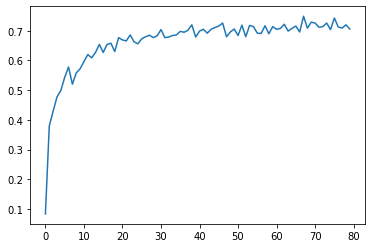

In [452]:
plt.plot(accs)

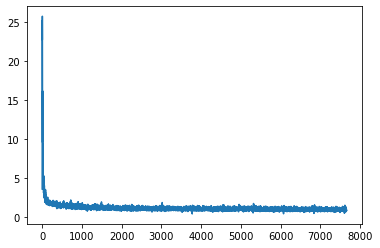

In [450]:
plt.plot(losses)